In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.layers import Embedding ,GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,LSTM, Dropout
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

In [4]:
# Read the contents of the English text file
with open('Dataset/english-corpus.txt', 'r',encoding="utf8") as file:
    english_lines = file.readlines()

# Read the contents of the Urdu text file
with open('Dataset/urdu-corpus.txt', 'r',encoding="utf8") as file:
    urdu_lines = file.readlines()

# Create a DataFrame
df = pd.DataFrame({'English': english_lines, 'Urdu': urdu_lines})

# Optional: Remove newline characters from the strings
df['English'] = df['English'].str.strip()
df['Urdu'] = df['Urdu'].str.strip()

# Print the DataFrame
print(df)

                     English                       Urdu
0        is zain your nephew      زین تمہارا بھتیجا ہے۔
1       i wish youd trust me  کاش تم مجھ پر بھروسہ کرتے
2           did he touch you      کیا اس نے آپ کو چھوا؟
3           its part of life         اس کی زندگی کا حصہ
4             zain isnt ugly        زین بدصورت نہیں ہے۔
...                      ...                        ...
24520  i am in a hurry today       میں آج جلدی میں ہوں۔
24521     take this medicine               یہ دوا لے لو
24522       this is the case               یہ معاملہ ہے
24523            zains tipsy                   زین ٹپسی
24524         i am not angry         میں ناراض نہیں ہوں

[24525 rows x 2 columns]


In [5]:
# Separating the English and Urdu datasets
eng = df['English']
urdu = df['Urdu']

eng_word_counter = Counter([word for sentence in eng for word in sentence.split()])
print("Total count of English words:",len([word for sentence in eng for word in sentence.split()]))
print("Count of distinct English words:",len(eng_word_counter))
print("10 most common English words:",list(zip(*eng_word_counter.most_common(10)))[0])

urdu_word_counter = Counter([word for sentence in urdu for word in sentence.split()])
print("Total count of Urdu words:",len([word for sentence in urdu for word in sentence.split()]))
print("Count of distinct Urdu words:",len(urdu_word_counter))
print("10 most common Urdu words:",list(zip(*urdu_word_counter.most_common(10)))[0])


Total count of English words: 98660
Count of distinct English words: 5766
10 most common English words: ('i', 'is', 'you', 'zain', 'a', 'he', 'the', 'it', 'to', 'am')
Total count of Urdu words: 123458
Count of distinct Urdu words: 5986
10 most common Urdu words: ('میں', 'ہے', 'زین', 'نے', 'نہیں', 'آپ', 'کیا', 'یہ', 'وہ', 'ہے۔')


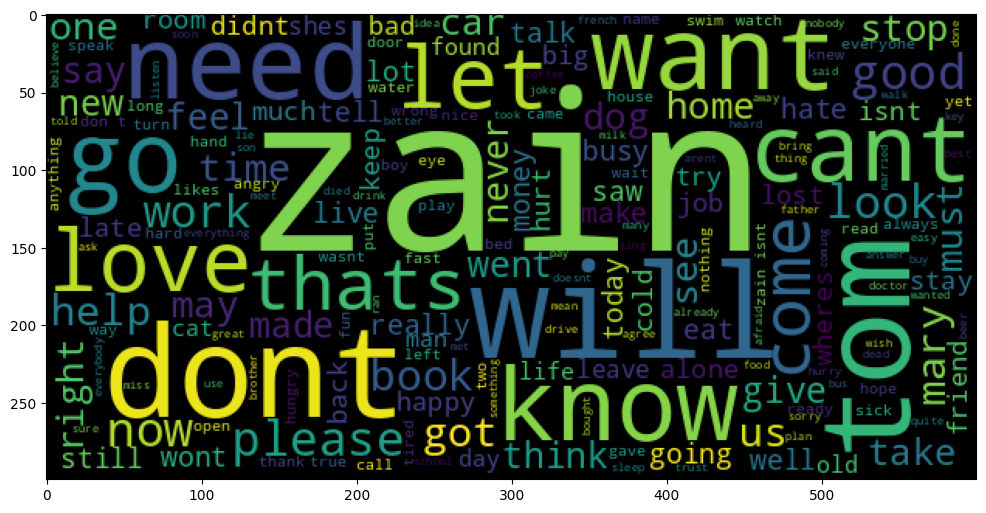

In [ ]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300).generate(' '.join(eng))
plt.imshow(wc)
plt.show();

In [ ]:
def word_count(line):
    return len(line.split())

In [ ]:
df['English_word_count'] = df['English'].apply(lambda x: word_count(x))
df['Urdu_word_count'] = df['Urdu'].apply(lambda x: word_count(x))

df['English_word_count']

0        4
1        5
2        4
3        4
4        3
        ..
24520    6
24521    3
24522    4
24523    2
24524    4
Name: English_word_count, Length: 24525, dtype: int64

In [ ]:
df['Urdu_word_count']

0        4
1        6
2        6
3        5
4        4
        ..
24520    5
24521    4
24522    3
24523    2
24524    4
Name: Urdu_word_count, Length: 24525, dtype: int64

<ipython-input-8-f446477d3a1d>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['English_word_count'],ax=axes[0])
<ipython-input-8-f446477d3a1d>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Urdu_word_count'],ax=axes[1])


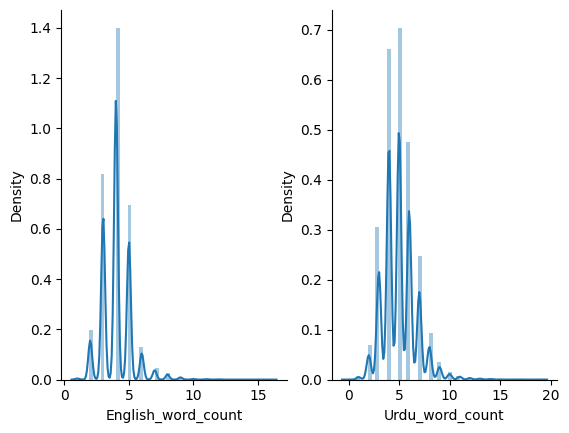

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1,ncols=2)
sns.distplot(df['English_word_count'],ax=axes[0])
sns.distplot(df['Urdu_word_count'],ax=axes[1])
sns.despine()
plt.show();

In [ ]:
def tokenize(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

tokenized_urdu_sentences,urdu_tokenizer = tokenize(df['Urdu'])

tokenized_urdu_sentences

[[3, 346, 2580, 10],
 [355, 29, 87, 31, 186, 73],
 [7, 11, 4, 6, 14, 2581],
 [11, 15, 205, 21, 913],
 [3, 974, 5, 10],
 [60, 16, 975, 20, 738, 55],
 [1, 4, 24, 11, 16, 1804],
 [1, 8, 88, 20, 25, 18],
 [1, 4, 13, 237, 356, 7],
 [3, 553, 5, 213, 49],
 [3, 3428, 25, 27],
 [1, 4, 3, 136, 806, 206],
 [29, 46, 88, 113, 22],
 [9, 86, 739, 10],
 [1111, 22, 34],
 [7, 22, 25, 2, 109, 188],
 [3, 4, 74, 408, 152],
 [3, 256],
 [60, 105, 2],
 [7, 8, 46, 19, 93, 36],
 [3, 4, 199, 9, 54],
 [322, 1036],
 [3, 14, 2084, 15, 59, 10],
 [1, 97, 131, 5, 315],
 [1, 26, 315, 71, 18],
 [9, 2085, 16, 620, 71, 2],
 [12, 39, 2086, 5, 10],
 [45, 554, 76, 2],
 [1, 360, 18],
 [9, 24, 26, 33, 32, 2],
 [1, 1112, 16, 112, 23],
 [9, 13, 409, 3429, 2],
 [1202, 15, 1037, 120, 2],
 [118, 4, 35, 14, 5, 79],
 [9, 5, 169, 49],
 [12, 11, 31, 774, 5, 10],
 [8, 3430, 238, 646, 31, 465, 22, 25, 10],
 [592, 24, 857],
 [6, 13, 305, 22],
 [37, 170, 1, 3, 2582, 10],
 [7, 8, 518, 36],
 [3431, 7, 2],
 [24, 3432, 1, 2087],
 [675, 15, 343

In [ ]:
tokenized_english_sentences, english_tokenizer = tokenize( df['English'])

tokenized_english_sentences

import pickle
# Save the tokenizer to a file
with open('english_tokenizer.pkl', 'wb') as file:
    pickle.dump(english_tokenizer, file)

In [ ]:
def pad(x):
    return pad_sequences(x, maxlen = 10, padding = 'post')

In [ ]:
preproc_urdu_sentences = pad(tokenized_urdu_sentences)

preproc_urdu_sentences[0]

array([   3,  346, 2580,   10,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [ ]:
preproc_english_sentences = pad(tokenized_english_sentences)

preproc_english_sentences[0]

array([   2,    4,   22, 2336,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [ ]:
max_english_sequence_length = preproc_english_sentences.shape[1]
max_urdu_sequence_length = preproc_urdu_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
urdu_vocab_size = len(urdu_tokenizer.word_index)

print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_urdu_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("urdu vocabulary size:", urdu_vocab_size)

Max English sentence length: 10
Max French sentence length: 10
English vocabulary size: 5678
urdu vocabulary size: 5929


In [ ]:
def bd_model(input_shape, output_sequence_length, urdu_vocab_size, english_vocab_size):

    learning_rate = 0.001

    # Build the layers
    model = Sequential()
    model.add(Embedding(english_vocab_size, 256, input_length=input_shape[1]))
    model.add(Bidirectional(GRU(256, return_sequences=True)))
    model.add(TimeDistributed(Dense(1024, activation='leaky_relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(urdu_vocab_size, activation='softmax')))
    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

In [ ]:
# Train
model = bd_model(
    preproc_english_sentences.shape,
    preproc_urdu_sentences.shape[1],
    len(urdu_tokenizer.word_index)+1,
    len(english_tokenizer.word_index)+1)

model.summary()

history=model.fit(preproc_english_sentences, preproc_urdu_sentences, batch_size=64, epochs=10, validation_split=0.3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 256)           1453824   
                                                                 
 bidirectional (Bidirectiona  (None, 10, 512)          789504    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 10, 1024)         525312    
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 10, 1024)          0         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 5930)         6078250   
 tributed)                                                       
                                                        

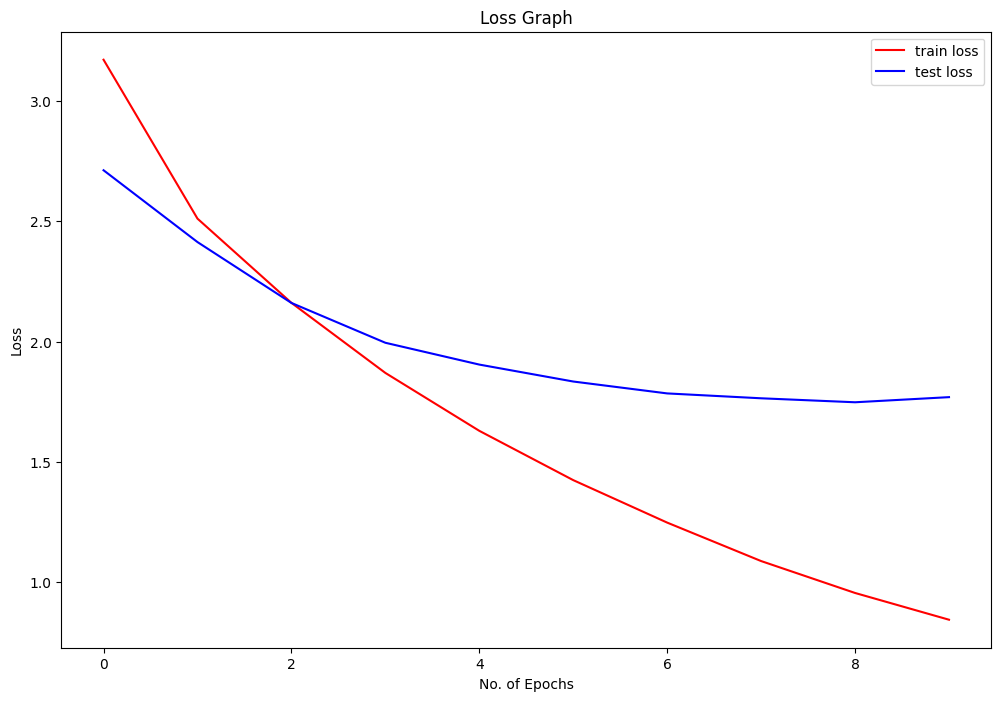

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],'r',label='train loss')
plt.plot(history.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();


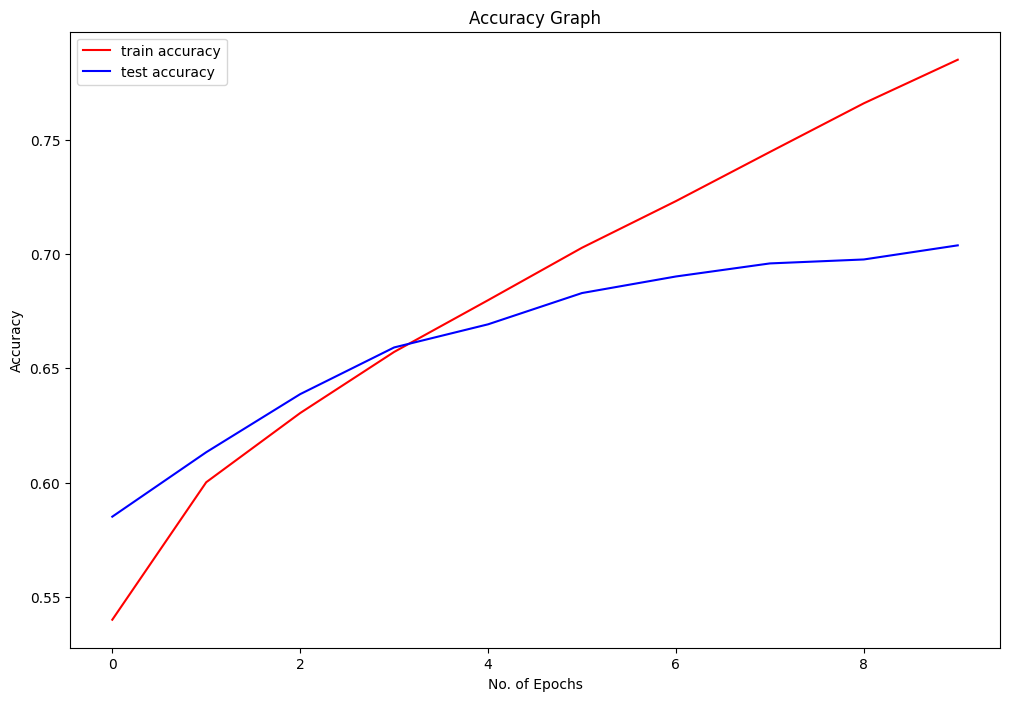

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'],'r',label='train accuracy')
plt.plot(history.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [ ]:
model.save('english_to_urdu_translator_final.h5')

In [ ]:
def logits_to_text(logits, tokenizer):

    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [ ]:
from tensorflow.keras.models import load_model
translator_model = load_model('english_to_urdu_translator_final.h5')
translator_model

i=1

print(preproc_english_sentences[i])
print("Prediction:")
prediction = translator_model.predict(preproc_english_sentences[i].reshape(1, -1))
predicted_text = logits_to_text(prediction[0], urdu_tokenizer)
print(predicted_text)

print("\nCorrect Translation:")
print(urdu[i])

print("\nOriginal text:")
print(eng[i])

[  1 222 689 274  12   0   0   0   0   0]
Prediction:
1/1 [==============================] - 1s 877ms/step
کاش تم آپ پر بھروسہ <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
کاش تم مجھ پر بھروسہ کرتے

Original text:
i wish youd trust me
